## ECFPinvert
hello welcome to the ECFPinvert notebook. This contains some examples of how to use the inverter class. Let's start with picking some radius and length of our fp

In [3]:
import inverter
import rdkit
from rdkit import Chem
RADIUS = 3
NBITS = 2048
inv = inverter.Inverter(nbits=NBITS,radius=RADIUS,atoms_dict=inverter.ATOMSDICT,add_charges=False)

reconstructing a fairly simple molecule: Gabapentin 

starting molecule:


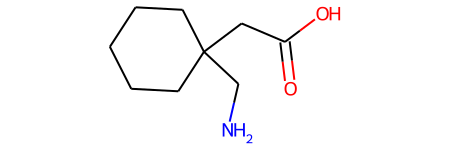

starting inversion ...


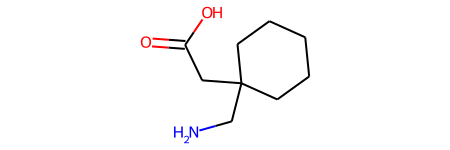

did it in 12 steps


In [4]:
mol = Chem.MolFromSmiles("O=C(O)CC1(CN)CCCCC1")
print("starting molecule:")
display(mol)
ifp = inv.getECFP(mol)
print("starting inversion ...")
winner,steps = inv.invert(ifp,verbose=False,max_steps=5000,max_atoms=30,reduction_tolerance=10,max_dummies=6)
display(winner)
print("did it in {} steps".format(steps))

# GDB inversion
As was discussed in the poster at GCC 2022, the inversion algorithm can tackle the smaller end of the GDB set quite well. A small subset (250 randomly sampled molecules) of gdb-7 to 11 each is provided (for the full set, go to reymond group website and make sure to read the terms and conditions https://gdb.unibe.ch/downloads/). Note that due to some enhancements in algorithm implementation the numbers are better than those in the poster.

In [3]:
import csv
import time
inv = inverter.Inverter(nbits=NBITS,radius=RADIUS,atoms_dict=inverter.ATOMSDICT)

verbose=True
for curr_set in ["07","08","09","10","11"]:
    hits=0
    count=0
    startat=0
    t1=time.time()
    with open("data/{}_250.smi".format(curr_set), newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='"')
        for row in reader:
            if row[0]!="smiles":
                if count>=startat:
                    cm = Chem.MolFromSmiles(row[0])
                    fp = inv.getECFP(cm)
                    try:
                        winner,steps = inv.invert(fp, verbose=False,max_steps=5000,max_atoms=12,reduction_tolerance=10)
                    except:
                        if verbose==True:
                            print(row[0],"error message ????")
                if winner!=None:
                    hits+=1
                else:
                    if verbose==True:
                        print("horrible failure for {}".format(row[0]))
                count +=1
                if count%100==0 and count>startat:
                    if verbose==True:
                        print("recovery rate is currently {}. out of {} molecules,current mol: {},time per mol={}".format(round(hits/count,3),count,row[0],(time.time()-t1)/(count-startat)))
    print("set {} finished with {} out of {} molecules found. that's {} percent".format(curr_set,hits, count,round(100*hits/count,3)))

recovery rate is currently 1.0. out of 100 molecules,current mol: C1OCC2CC2O1,time per mol=0.16713340044021607
recovery rate is currently 1.0. out of 200 molecules,current mol: C=COC(=O)C#N,time per mol=0.17966861128807068
set 07 finished with 250 out of 250 molecules found.
recovery rate is currently 1.0. out of 100 molecules,current mol: CCC1=NC(=C)CN1,time per mol=0.2398168921470642
recovery rate is currently 1.0. out of 200 molecules,current mol: CCCC=CC(F)F,time per mol=0.23281684756278992
set 08 finished with 250 out of 250 molecules found.
recovery rate is currently 1.0. out of 100 molecules,current mol: CC#CC1CCNN=C1,time per mol=0.5345563244819641
recovery rate is currently 1.0. out of 200 molecules,current mol: CC(F)C1=CC2CC2C1,time per mol=0.5647636079788207
set 09 finished with 250 out of 250 molecules found.
horrible failure for C1CN2C3C4C1C5C(C34)C25
recovery rate is currently 0.99. out of 100 molecules,current mol: CCN1CCCC1CCN,time per mol=1.728056492805481
recovery rat

# Changing the fragment corpus
the "ATOMSDICT" contains the atoms that are being used, normally just CNOF. in case you want the full set you can initialize the ATOMSDICT_FULL instead. see below where VX a molecule containing P and S is reconstructed:

starting molecule:


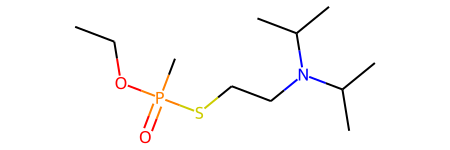

starting inversion ...


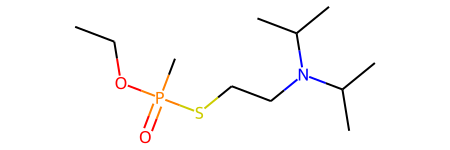

did it in 23 steps


In [5]:
inv = inverter.Inverter(nbits=NBITS,radius=RADIUS,atoms_dict=inverter.ATOMSDICT_FULL)
mol = Chem.MolFromSmiles("CCOP(C)(=O)SCCN(C(C)C)C(C)C")
print("starting molecule:")
display(mol)
ifp = inv.getECFP(mol)
print("starting inversion ...")
winner,steps = inv.invert(ifp,verbose=False,max_steps=5000,max_atoms=30,reduction_tolerance=10,max_dummies=6)
display(winner)
print("did it in {} steps".format(steps))

# Adding charges
It is also possible to make use of charges. Often sets like ChEMBL will contain charged amines, carboxylates and so on. In case the corpus contains charged atoms this is no problem. This functionality can be turned on using flag add_charges during initialization. A theoretical molecule with some charges is shown.

starting molecule:


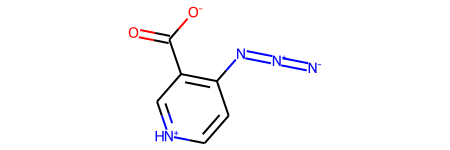

starting inversion ...


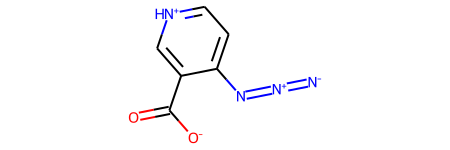

did it in 84 steps


In [6]:
inv = inverter.Inverter(nbits=NBITS,radius=RADIUS,atoms_dict=inverter.ATOMSDICT_FULL,add_charges=True)
mol = Chem.MolFromSmiles("c1c[nH+]cc(C(=O)[O-])c1N=[N+]=[N-]")
print("starting molecule:")
display(mol)
ifp = inv.getECFP(mol)
print("starting inversion ...")
winner,steps = inv.invert(ifp,verbose=False,max_steps=5000,max_atoms=30,reduction_tolerance=10,max_dummies=6)
display(winner)
print("did it in {} steps".format(steps))

# inverting "Big molecules"
the currently given examples are fairly small molecules (although in the gdb case, complex for their size).
the inversion algorithm can also invert bigger molecules with complex fused systems, but it takes a while. for example, the LSD molecule below (protonated state) takes 395 steps and some seconds to reconstruct. Some other molecules of this size cannot be reconstructed, quantifying this is TBD and forthcoming, early data suggests about 2/3 of ChEMBL like molecules can be reconstructed.

starting molecule:


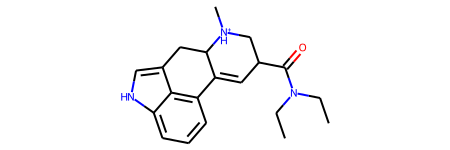

starting inversion ...


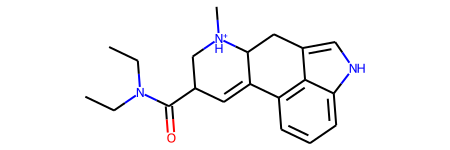

did it in 395 steps


In [9]:
inv = inverter.Inverter(nbits=NBITS,radius=RADIUS,atoms_dict=inverter.ATOMSDICT,add_charges=True)
mol = Chem.MolFromSmiles("CCN(CC)C(=O)C1C[NH+](C2CC3=CNC4=CC=CC(=C34)C2=C1)C")
print("starting molecule:")
display(mol)
ifp = inv.getECFP(mol)
print("starting inversion ...")
winner,steps = inv.invert(ifp,verbose=False,max_steps=5000,max_atoms=30,reduction_tolerance=10,max_dummies=6)
display(winner)
print("did it in {} steps".format(steps))